<a href="https://colab.research.google.com/github/avionerman/computational_and_statistical/blob/main/CI%26SL3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libs

In [2]:

#!pip uninstall tensorflow -y
#!pip install tensorflow==2.16.1
!pip install --upgrade ml_dtypes tensorflow

import numpy as np
from numpy.linalg import eigh, eig, svd, norm, inv
from scipy.sparse import csr_matrix, diags, eye as sparse_eye
from scipy.sparse.linalg import eigsh, eigs
from scipy.spatial.distance import cdist, pdist, squareform
from scipy.sparse.csgraph import shortest_path


from sklearn.neighbors import NearestNeighbors, kneighbors_graph
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.manifold import TSNE, Isomap, LocallyLinearEmbedding
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import (
    adjusted_rand_score,
    normalized_mutual_info_score,
    homogeneity_score,
    completeness_score,
    v_measure_score,
    confusion_matrix,
    accuracy_score
)
from sklearn.decomposition import PCA


import matplotlib.pyplot as plt
import seaborn as sns

from dataclasses import dataclass, field
from typing import List, Dict, Optional, Tuple
from enum import Enum, auto
import warnings
import time

warnings.filterwarnings('ignore')

# set random seeds for reproducibility for the rest of the code
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 183.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 160.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 75.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.0/225.0 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 7.1 MB/s eta 0:00:00


# Configuration attributes

In [3]:
@dataclass
class Config:

    # data
    sample_fraction: float = 0.67      # using x% of the data for faster experimenting
    normalize_method: str = 'minmax'   # avail options: 'minmax', 'standard'
    random_seed: int = 42

    # graph
    n_neighbors: int = 10 # k for kNN graph
    sigma: float = None   # gaussian kernel bandwidth (none = auto-estimate)

    # enable/disable methods
    enable_laplacian_eigenmaps: bool = True
    enable_lpp: bool = True
    enable_isomap: bool = True
    enable_lle: bool = True
    enable_tsne: bool = True

    # spectral settings
    n_clusters_list: List[int] = field(default_factory=lambda: [2, 3, 5, 7, 10])

    # tSNE only
    tsne_perplexity: float = 30.0
    tsne_n_iter: int = 1000


config = Config()

print(">>> Configuration set")
print(f"   Sample fraction: {config.sample_fraction * 100:.0f}%")
print(f"   n_neighbors: {config.n_neighbors}")
print(f"   Methods enabled: LE={config.enable_laplacian_eigenmaps}, LPP={config.enable_lpp}, "
      f"Isomap={config.enable_isomap}, LLE={config.enable_lle}, t-SNE={config.enable_tsne}")

>>> Configuration set
   Sample fraction: 67%
   n_neighbors: 10
   Methods enabled: LE=True, LPP=True, Isomap=True, LLE=True, t-SNE=True


# Data preprocessing

In [4]:
def load_mnist():
    from tensorflow.keras.datasets import mnist
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    class_names = [str(i) for i in range(10)]
    return x_train, y_train, x_test, y_test, class_names

def load_cifar10():
    from tensorflow.keras.datasets import cifar10
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    y_train, y_test = y_train.flatten(), y_test.flatten()
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']
    return x_train, y_train, x_test, y_test, class_names

def sample_data(x, y, fraction, random_seed=RANDOM_SEED):
    from sklearn.model_selection import train_test_split

    x_sample, _, y_sample, _ = train_test_split(
        x, y,
        train_size=fraction,
        stratify=y, # enable stratification for fair representation
        random_state=random_seed
    )
    return x_sample, y_sample

def preprocess_data(x, y, config):
    # sample, flatten, normalize to [0,1].

    # handle 100% of data (skip sampling)
    if config.sample_fraction >= 1.0:
        x_sampled, y_sampled = x, y
    else:
        x_sampled, y_sampled = sample_data(x, y, config.sample_fraction, config.random_seed)

    # flatten and normalize (images are 0-255 move under scale to 0-1)
    x_flat = x_sampled.reshape(len(x_sampled), -1).astype(np.float32) / 255.0

    return x_flat, y_sampled

# Data loading

In [5]:
# loading MNIST
print(">>> Loading MNIST")
x_train_mnist, y_train_mnist, x_test_mnist, y_test_mnist, mnist_classes = load_mnist()
x_mnist, y_mnist = preprocess_data(x_train_mnist, y_train_mnist, config)
print(f"MNIST: {x_mnist.shape[0]} samples, {x_mnist.shape[1]} features")

# loading CIFAR10
print(">>> Loading CIFAR10")
x_train_cifar, y_train_cifar, x_test_cifar, y_test_cifar, cifar_classes = load_cifar10()
x_cifar, y_cifar = preprocess_data(x_train_cifar, y_train_cifar, config)
print(f"CIFAR10: {x_cifar.shape[0]} samples, {x_cifar.shape[1]} features")

print(">>> Data loaded and preprocessed")

>>> Loading MNIST
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
MNIST: 40200 samples, 784 features
>>> Loading CIFAR10
170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
CIFAR10: 33500 samples, 3072 features
>>> Data loaded and preprocessed


# Datasets visualization

In [6]:
def visualize_samples(x_original, y, class_names, dataset_name, n_samples=5):
    # present sample images from each class
    n_classes = len(class_names)
    fig, axes = plt.subplots(n_classes, n_samples, figsize=(n_samples * 1.5, n_classes * 1.5))
    fig.suptitle(f'{dataset_name}: Sample Images', fontsize=14)

    for row, cls in enumerate(range(n_classes)):
        # get images of this class
        cls_indices = np.where(y == cls)[0]
        selected = np.random.choice(cls_indices, size=n_samples, replace=False)

        for col, idx in enumerate(selected):
            ax = axes[row, col]
            img = x_original[idx]

            # handling grayscale (MNIST) vs rbg (CIFAR10)
            if len(img.shape) == 2:
                ax.imshow(img, cmap='gray')
            else:
                ax.imshow(img)

            ax.axis('off')
            if col == 0:
                ax.set_title(class_names[cls], fontsize=10)

    plt.tight_layout()
    plt.show()



# visualize_samples(x_train_mnist, y_train_mnist, mnist_classes, 'MNIST')
print("\n\n")
# visualize_samples(x_train_cifar, y_train_cifar, cifar_classes, 'CIFAR10')

# Graph creation

In [7]:
def build_knn_graph(x, n_neighbors):
    """
    finds k nearest neighbors for each point
    returning symmetric binary adjacency matrix
    mode -> connectivity: matrix should be binary (1: connection, 0: no connection)
    include_self: ensures a point is not considered its own neighbor
    """
    knn = kneighbors_graph(x, n_neighbors, mode='connectivity', include_self=False)

    # symmetric transformation:
    # if there's an edge from i to j or from j to i
    # it will be present in adjacency
    adjacency = knn + knn.T

    # if both i is neighbor of j and j is neighbor of i, then the entry will be 2
    # so I convert them to 1, or I keep them as 0 if it's 0 already
    adjacency = (adjacency > 0).astype(np.float64)

    return adjacency.toarray()

def compute_gaussian_weights(x, adjacency, sigma=None):
    """
    converts distances to similarities using Gaussian kernel
    compute Gaussian kernel weights (used formula from pdf)
    W_ij = exp(-||x_i - x_j||^2 / (2 * sigma^2))
    """
    distances = cdist(x, x, 'euclidean')

    # estimate sigma IF not provided (median)
    if sigma is None:

      # considers distances between points that are k nearest neighbors
        connected_distances = distances[adjacency > 0]

        # if sigma is none, will be calculated using distances' median
        sigma = np.median(connected_distances)

    # closer to 1: better similarity
    # closer to 0, the opposite
    W = np.exp(-distances**2 / (2 * sigma**2))

    # all the entries (where adjacency is 0) become 0
    # meaning non-neighbors have zero similarity
    W = W * adjacency
    np.fill_diagonal(W, 0)

    return W, sigma

def build_similarity_graph(x, n_neighbors, sigma=None):
    """
    combines both steps + computes degree matrix
    and then building complete similarity graph
    returning W (matrix), D (matrix) and which sigma used
    """
    adjacency = build_knn_graph(x, n_neighbors)
    W, sigma = compute_gaussian_weights(x, adjacency, sigma)
    D = np.diag(W.sum(axis=1))  # degree matrix

    return W, D, sigma

# Method 1: Laplacian Eigenmap [LE]

In [8]:
def laplacian_eigenmaps(x, n_components=2, n_neighbors=15, sigma=None):
    """
    Laplacian Eigenmaps for dimensionality reduction:

    1. building similarity graph (W and D)
    2. calculating Laplacian L = D - W
    3. normalization with L_rows = D^(-1) @ L
    4. finding the actual eigenvectors
    5. returnin at the end the 2nd to (n_components+1)th eigenvectors
    """
    # 1: building similarity graph
    W, D, sigma = build_similarity_graph(x, n_neighbors, sigma)

    # 2: calculating Laplacian
    L = D - W

    # 3: normalization with (L_rows = D^(-1) @ L)

    # small value to avoid division by zero
    D_inv = np.diag(1.0 / (np.diag(D) + 1e-10))
    L_rows = D_inv @ L

    # 4: finding the actual eigenvectors
    eigenvalues, eigenvectors = eigh(L_rows)

    # sorting by eigenvalue and skip the first eigenvector (useless)
    idx = np.argsort(eigenvalues)
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]

    # 5: returnin at the end the 2nd to (n_components+1)th eigenvectors
    embedding = eigenvectors[:, 1:n_components + 1]

    return embedding, eigenvalues


print(">>> Laplacian Eigenmaps executed")

>>> Laplacian Eigenmaps executed


# Method 2: Locality Preserving Projections [LPP]

In [9]:
def lpp(x, n_components=2, n_neighbors=15, sigma=None):
    """
    LPP - Linear approximation of Laplacian Eigenmaps

    key difference from LE:
    - LE gives embedding (positions)
    - LPP gives projection matrix (can project new data) - using Euclidean distances

    I want to solve the X @ L @ X.T @ w = λ @ X @ D @ X.T @ w
    formula was used after reading the following paper:
    https://proceedings.neurips.cc/paper/2003/file/d69116f8b0140cdeb1f99a4d5096ffe4-Paper.pdf
    """
    from scipy.linalg import eigh as scipy_eigh

    n_samples, n_features = x.shape

    # 1: building similarity graph (same as LE but for LPP this time)
    W, D, sigma = build_similarity_graph(x, n_neighbors, sigma)

    # 2: calculating Laplacian
    L = D - W

    # 3: calculating scatter matrices
    # X.T has shape (features, samples)
    # XLXT has shape (features, features)
    XLXT = x.T @ L @ x # (784, 784) - what relation exists through Laplacian
    XDXT = x.T @ D @ x # w will be (784,) a weight per feature - what relation exists through connectivity

    # 4: regularization (avoid singular matrix)
    # np.trace(XDXT) = sum of all diagonal elements (matrix size)
    reg = 1e-6 * np.trace(XDXT) / n_features # dividing with n_features to get the avg
    XDXT_reg = XDXT + reg * np.eye(n_features) # append to the diagonal

    # 5: fix generalized eigenvalue problem
    # scipy_eigh() is finding the values and vectors of an eigen
    # A*v = λ*B*v using this formula
    # vectors are the projection weights
    # values are the numbers telling me how good each weight is
    eigenvalues, eigenvectors = scipy_eigh(XLXT, XDXT_reg)

    # 6: find eigenvalues that are NOT near zero (skip meaningless ones)
    threshold = 1e-10
    valid_idx = np.where(eigenvalues > threshold)[0]

    # sort the valid eigenvalues (smallest first)
    valid_eigenvalues = eigenvalues[valid_idx]
    sorted_valid_idx = valid_idx[np.argsort(valid_eigenvalues)]

    # picks the 2 eigenvector columns that have the smallest valid eigenvalues for 2D result
    projection_matrix = eigenvectors[:, sorted_valid_idx[:n_components]]

    # 7: data projection
    """
            x                  projection_matrix                embedding
    | 15000 images    |       |   784 weights   |     =  | 15000 points in 2D |
    |                 |   X   |                 |        |                    |
    | with 784 pixels |       | for each of 2D  |        | (x, y) coordinates |
    """
    embedding = x @ projection_matrix

    return embedding, projection_matrix, eigenvalues


def lpp_project_new_data(x_new, projection_matrix):
    """
    projecting new data using learned LPP projection matrix - big diff from LE that needs to recalculate
    """
    return x_new @ projection_matrix


print(">>> LPP executed")

>>> LPP executed


# Method 3: Isometric Mapping [ISOMAP]

In [10]:
def isomap(x, n_components=2, n_neighbors=15):
    """
    Isomap - Isometric Mapping

    Concept:
    - using Geodesic distance (along the surface) instead of Euclidean (straight line)
    - Good for "unfolding" curved data like "swiss roll"

    How it works:
    1. building a k-NN graph (connecting nearby points)
    2. calculating the shortest path between all pairs (approximates geodesic distance)
    3. applying MDS (multidimensional scaling) to preserve these distances in 2D

    the following paper was used:
    https://www.science.org/doi/10.1126/science.290.5500.2319
    """
    from sklearn.manifold import Isomap as SklearnIsomap

    model = SklearnIsomap(
        n_components=n_components,  # output dimensions (2 for 2D)
        n_neighbors=n_neighbors     # k in kNN graph
    )

    embedding = model.fit_transform(x)

    return embedding, model


print(">>> Isomap executed")

>>> Isomap executed


# Model 4: Locally Linear Embedding [LLE]

In [11]:
def lle(x, n_components=2, n_neighbors=15):
    """
    LLE - Locally Linear Embedding

    Concept:
    - each point can be reconstructed as a weighted sum of its neighbors
    - finding 2D positions where the same weights still work
    - preserving local geometry without using distances

    How it works:
    1. for each point, find weights that reconstruct it from neighbors
       Point_i ≈ w1*Neighbor1 + w2*Neighbor2 + ... + wk*Neighbork
    2. finding 2D coordinates where these same weights still reconstruct each point

    Key difference from other methods:
    - LE/LPP: uses distances (Euclidean) → weights (Gaussian kernel)
    - Isomap: uses distances (Geodesic)
    - LLE: uses reconstruction weights directly (without distances)

    example:

    A(1, 1) | B(2, 4) | C(4, 1) | D(3, -1)

    for LE/LPP (after calc distances and using the W formula - random numbers)
      Wab = 0.29
      Wac = 0.32
      Wad = 0.37

    for LLE:
      A = w1*b + w2*c + w3*d => (1,1) = w1*(2,4) + w2*(4,1) + w3*(3,-1)
      constraints: w1+w2+w3=1 and I need to minimize the reconstruction error

      x; 1 = 2*w1 + 4*w2 + 3*w3
      y; 1 = 4*w1 + 1*w2 + -1*w3
      constraint; 1 = w1+w2+w3

      result: w1 = 0.1, w2 = 0.6, w3 = 0.3

    does that mean C is the best with 0.6? Not really, this is not about calculating distance
    but gives a weight on the point that could help the reconstruction of the code point (in this case A)

    the following paper was used:
    https://www.science.org/doi/10.1126/science.290.5500.2323
    """
    from sklearn.manifold import LocallyLinearEmbedding

    model = LocallyLinearEmbedding(
        n_components=n_components,  # output dimensions (2 for 2D)
        n_neighbors=n_neighbors,    # k neighbors for reconstruction
        method='standard'           # standard LLE algorithm (other options: modified, hessian, ltsa)
    )

    embedding = model.fit_transform(x)

    return embedding, model


print(">>> LLE executed")

>>> LLE executed


# Model 5: t-Distributed Stochastic Neighbor Embedding [tSNE]

In [12]:
def tsne(x, n_components=2, perplexity=30.0, n_iter=10000):
    """
    t-SNE - t-Distributed Stochastic Neighbor Embedding

    Concept:
    - converting distances to probs (simply as "what's the chance point A picks point B as neighbor?")
    - finding 2D embedding where these probs match as closely as possible
    - creating the best visualization with clear cluster separation

    How it works:
    1. if there's high-D: compute prob that point i would pick point j as neighbor (Gaussian)
    2. if there's low-D: compute same prob (Student-t distribution)
    3. minimize the difference between these two prob distributions

    What about Student-t in low-D?
    - it has "heavier tails" than Gaussian
    - allowing distant points to spread out more in 2D
    - preventing the "crowding problem" (everything squished together)

    Important!
    - perplexity: this attribute defines roughly "how many neighbors to consider"

    the following paper was used:
    https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf
    """
    from sklearn.manifold import TSNE

    model = TSNE(
        n_components=n_components,  # output dimensions (2 for 2D)
        perplexity=perplexity,      # ~number of neighbors (default 30, typically something between 5-50)
        n_iter=n_iter,              # optimization iterations
        random_state=42             # for reproducibility
    )

    embedding = model.fit_transform(x)

    return embedding, model


print(">>> t-SNE executed")

>>> t-SNE executed


# Spectral Clustering

In [13]:
def spectral_clustering(x, n_clusters, n_neighbors=15):
    """
    Spectral Clustering - groups data into clusters using graph structure

    How it works:
    1. building similarity graph (like for LE)
    2. computing Laplacian eigenvectors
    3. using eigenvectors as new features
    4. applying k means on these features

    Important:
    for MNIST I know there are 10 classes, so I will expect 10 clusters
    if the class number is unknown, then I will have to experiment with the
    clusters number and find the appropriate outcome

    """
    from sklearn.cluster import SpectralClustering

    model = SpectralClustering(
        n_clusters=n_clusters,          # how many groups to create (comment above)
        affinity='nearest_neighbors',   # use kNN graph
        n_neighbors=n_neighbors,        # k of kNN
        random_state=42
    )

    # building graph, computing eigenvectors, running k means, and last returning labels
    cluster_labels = model.fit_predict(x)

    return cluster_labels, model

    print(">>> Spectral Clustering executed")

# Spectral Clustering Evaluation

In [14]:
def evaluate_clustering(true_labels, cluster_labels):
    """
    Evaluating how good the clustering is by comparing to true labels

    Metrics:
    - ARI (Adjusted Rand Index): -1 to 1, higher = better, 0 = random
    - NMI (Normalized Mutual Info): 0 to 1, higher = better
    - Homogeneity: if a cluster of digit x includes dots of another digit y, then it's not homogeneity
    - Completeness: if all dots of a class exist in the same cluster and nothing is missing, it's complete
    """

    from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, homogeneity_score, completeness_score

    ari = adjusted_rand_score(true_labels, cluster_labels)
    nmi = normalized_mutual_info_score(true_labels, cluster_labels)
    homogeneity = homogeneity_score(true_labels, cluster_labels)
    completeness = completeness_score(true_labels, cluster_labels)

    return {
        'ARI': ari,
        'NMI': nmi,
        'Homogeneity': homogeneity,
        'Completeness': completeness
    }

    print(">>> Evaluation of Spectral Clustering executed")

# Results Visualization

In [15]:
def plot_clustering_metrics_combined(df_results, n_clusters_list):
    """
    line graph (trends) + grouped bar chart (comparison)

    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))


    ax1 = axes[0]
    ax1.plot(df_results['n_clusters'], df_results['ARI'],           'o-', label='ARI',          linewidth=2, markersize=8)
    ax1.plot(df_results['n_clusters'], df_results['NMI'],           's-', label='NMI',          linewidth=2, markersize=8)
    ax1.plot(df_results['n_clusters'], df_results['Homogeneity'],   '^-', label='Homogeneity',  linewidth=2, markersize=8)
    ax1.plot(df_results['n_clusters'], df_results['Completeness'],  'd-', label='Completeness', linewidth=2, markersize=8)

    ax1.set_xlabel('num of clusters (k)')
    ax1.set_ylabel('score')
    ax1.set_title('Trends: metrics vs num of clusters')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_xticks(n_clusters_list)

    ax2 = axes[1]

    x = np.arange(len(n_clusters_list))
    width = 0.2
    metrics = ['ARI', 'NMI', 'Homogeneity', 'Completeness']
    colors = ['steelblue', 'coral', 'seagreen', 'mediumpurple']

    for i, (metric, color) in enumerate(zip(metrics, colors)):
        offset = (i - 1.5) * width
        bars = ax2.bar(x + offset, df_results[metric], width, label=metric, color=color)

        for bar in bars:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2, height + 0.01,
                    f'{height:.2f}', ha='center', va='bottom', fontsize=8)

    ax2.set_xlabel('num of clusters (k)')
    ax2.set_ylabel('score')
    ax2.set_title('Comparison: metrics by num of clusters')
    ax2.set_xticks(x)
    ax2.set_xticklabels([f'k={k}' for k in n_clusters_list])
    ax2.legend(loc='upper left')
    ax2.set_ylim(0, 1.15)
    ax2.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()


print(">>> Results Visualization executed")

>>> Results Visualization executed


In [16]:
def plot_clusters_on_embedding(embedding, n_clusters_list, n_neighbors=15):
    """
    showing how spectral clustering divides the space for different k values
    """
    n_plots = len(n_clusters_list)
    fig, axes = plt.subplots(1, n_plots, figsize=(6 * n_plots, 5))

    for ax, k in zip(axes, n_clusters_list):
        cluster_labels, _ = spectral_clustering(embedding, n_clusters=k, n_neighbors=n_neighbors)

        scatter = ax.scatter(embedding[:, 0], embedding[:, 1],
                            c=cluster_labels, cmap='tab10', s=5, alpha=0.7)
        ax.set_title(f'spectral clustering: k={k}')
        ax.set_xlabel('comp 1')
        ax.set_ylabel('comp 2')
        ax.grid(True, alpha=0.3)
        plt.colorbar(scatter, ax=ax, label='Cluster')

    plt.tight_layout()
    plt.show()

In [17]:
def plot_true_vs_predicted(embedding, y_true, n_clusters, n_neighbors=15):
    """
    comparing ground truth labels with clustering results
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # left side, true labels
    scatter1 = axes[0].scatter(embedding[:, 0], embedding[:, 1],
                               c=y_true, cmap='tab10', s=5, alpha=0.7)
    axes[0].set_title('true labels (Digits 0-9)')
    axes[0].set_xlabel('comp 1')
    axes[0].set_ylabel('comp 2')
    plt.colorbar(scatter1, ax=axes[0], label='Digit')
    axes[0].grid(True, alpha=0.3)

    # right side, cluster assignments
    cluster_labels, _ = spectral_clustering(embedding, n_clusters=n_clusters, n_neighbors=n_neighbors)
    scatter2 = axes[1].scatter(embedding[:, 0], embedding[:, 1],
                               c=cluster_labels, cmap='tab10', s=5, alpha=0.7)
    axes[1].set_title(f'spectral clustering (k={n_clusters})')
    axes[1].set_xlabel('comp 1')
    axes[1].set_ylabel('comp 2')
    plt.colorbar(scatter2, ax=axes[1], label='Cluster')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# MNIST Execution Pipeline

In [20]:
def run_mnist_pipeline(config):
    """
    dimensionality reduction + spectral clustering on MNIST.
    enable/disable methods via config flags.
    """
    embeddings = {}

    x_train, y_train, _, _, _ = load_mnist()
    x_data, y_data = preprocess_data(x_train, y_train, config)
    print(f"   {x_data.shape[0]} samples, {x_data.shape[1]} features\n")

    # dimensionality reduction methods
    methods = {
        'Laplacian Eigenmaps':  (config.enable_laplacian_eigenmaps, lambda: laplacian_eigenmaps (x_data, 2, config.n_neighbors)[0]),
        'LPP':                  (config.enable_lpp,                 lambda: lpp                 (x_data, 2, config.n_neighbors)[0]),
        'Isomap':               (config.enable_isomap,              lambda: isomap              (x_data, 2, config.n_neighbors)[0]),
        'LLE':                  (config.enable_lle,                 lambda: lle                 (x_data, 2, config.n_neighbors)[0]),
        't-SNE':                (config.enable_tsne,                lambda: tsne                (x_data, 2, config.tsne_perplexity, config.tsne_n_iter)[0])
    }

    for name, (enabled, method) in methods.items():
        if enabled:
            print(f"   ▶ {name}...")
            embeddings[name] = method()

    # visualize embeddings
    n_methods = len(embeddings)
    cols = min(3, n_methods)
    rows = (n_methods + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))
    axes = np.array(axes).flatten() if n_methods > 1 else [axes]

    for idx, (name, emb) in enumerate(embeddings.items()):
        ax = axes[idx]
        scatter = ax.scatter(emb[:, 0], emb[:, 1], c=y_data, cmap='tab10', s=5, alpha=0.7)
        ax.set_title(name)
        ax.set_xlabel('comp 1')
        ax.set_ylabel('comp 2')
        ax.grid(True, alpha=0.3)
        plt.colorbar(scatter, ax=ax, label='Digit')

    for idx in range(n_methods, len(axes)):
        axes[idx].set_visible(False)

    plt.suptitle('MNIST: Dimensionality Reduction Methods', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

    # spectral clustering: using t-SNE if available, else first available
    cluster_emb = embeddings.get('t-SNE', list(embeddings.values())[0])

    results = []
    for k in config.n_clusters_list:
        labels, _ = spectral_clustering(cluster_emb, k, config.n_neighbors)
        scores = evaluate_clustering(y_data, labels)
        scores['n_clusters'] = k
        results.append(scores)
        print(f"   k={k}: ARI={scores['ARI']:.3f}, NMI={scores['NMI']:.3f}")

    # visualize clustering results
    import pandas as pd
    df_results = pd.DataFrame(results)
    plot_clustering_metrics_combined(df_results, config.n_clusters_list)
    plot_clusters_on_embedding(cluster_emb, [2, 5, 10], config.n_neighbors)
    plot_true_vs_predicted(cluster_emb, y_data, 10, config.n_neighbors)

    return embeddings, df_results, y_data


print(">>> MNIST Pipeline executed")

>>> MNIST Pipeline executed


   40200 samples, 784 features

   ▶ Laplacian Eigenmaps...
   ▶ LPP...
   ▶ Isomap...
   ▶ LLE...
   ▶ t-SNE...


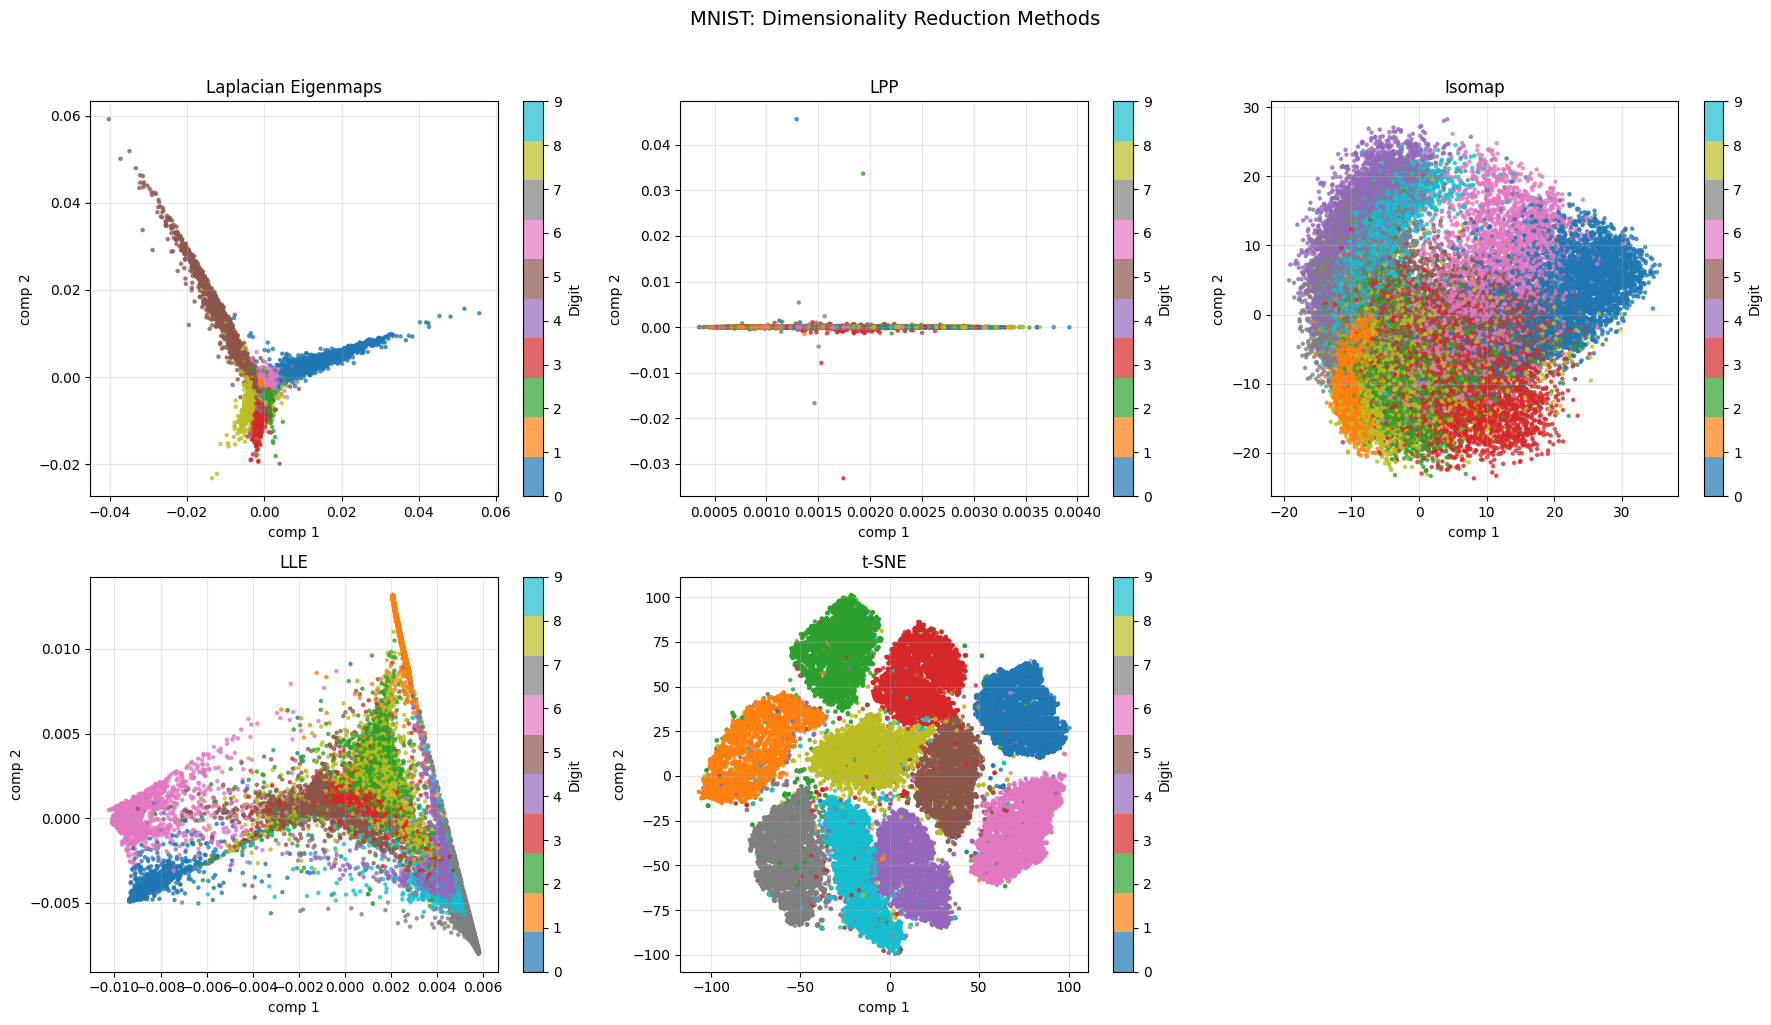

   k=2: ARI=0.000, NMI=0.001
   k=3: ARI=0.096, NMI=0.331
   k=5: ARI=0.161, NMI=0.458
   k=7: ARI=0.393, NMI=0.660
   k=10: ARI=0.655, NMI=0.782


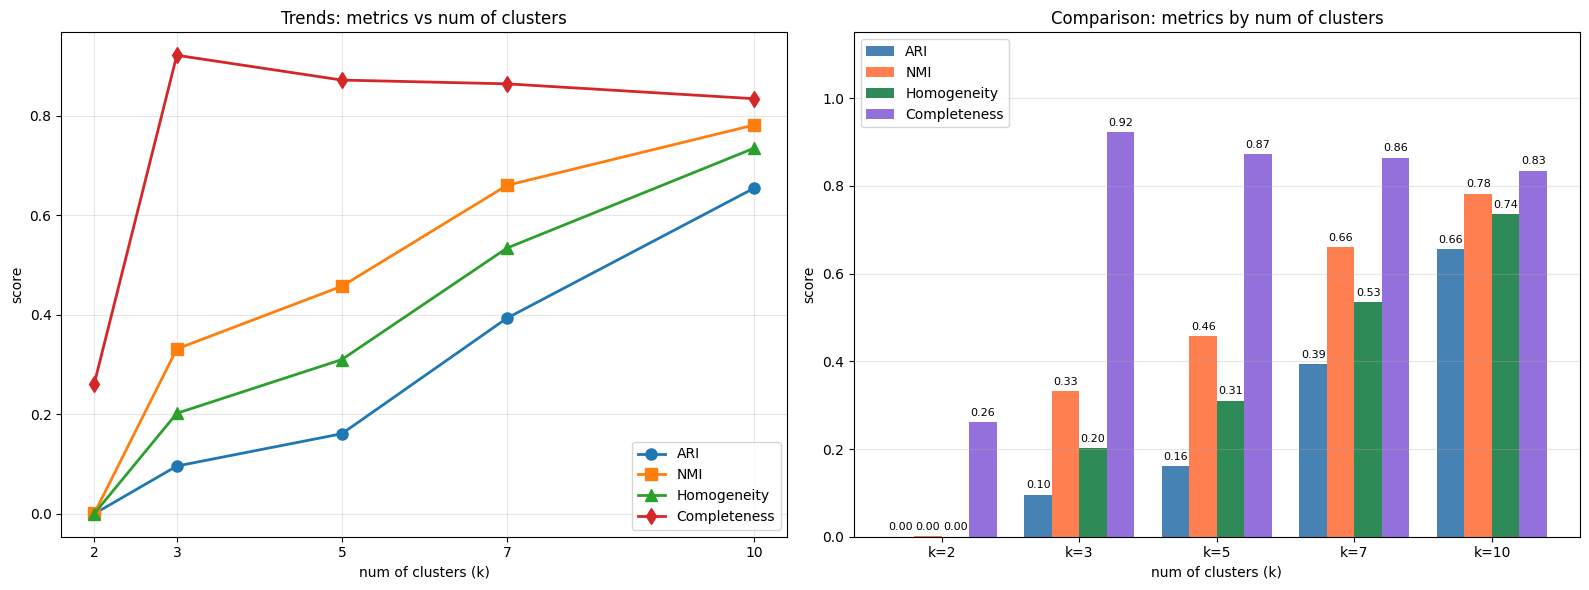

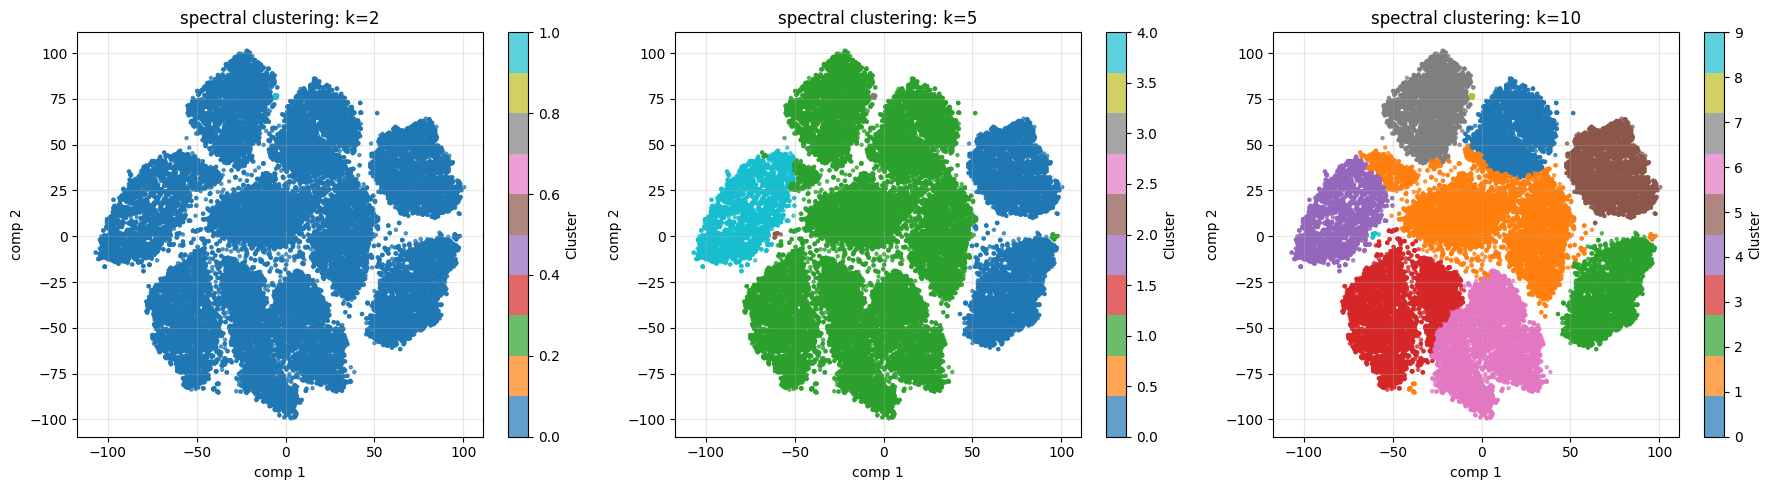

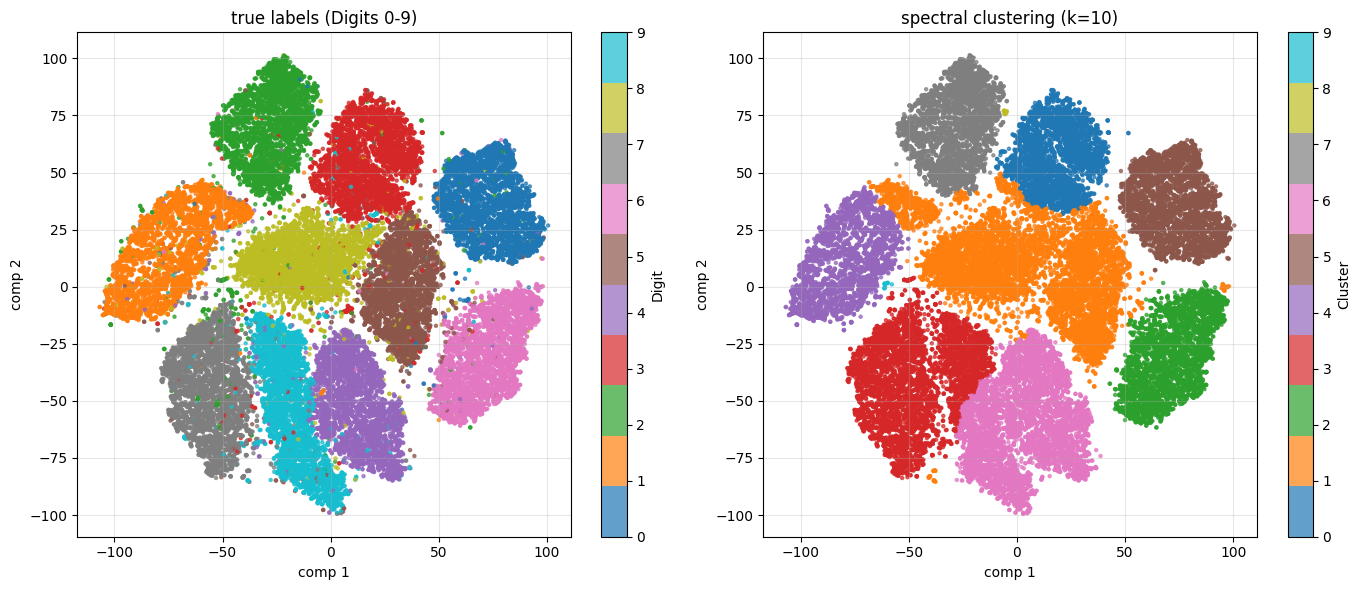

In [21]:
embeddings_mnist, results_mnist, y_mnist = run_mnist_pipeline(config)

